In [25]:
%env REQUESTS_CA_BUNDLE=/Library/Application Support/Netskope/STAgent/data/nscacert.pem

env: REQUESTS_CA_BUNDLE=/Library/Application Support/Netskope/STAgent/data/nscacert.pem


# Read dataset

Ejemplo de un archivo de reporte de errores en formato xml

In [6]:
import os
import xmltodict

dataset_path = 'dataset'
filename = os.listdir(dataset_path)[0]
file_path = os.path.join(dataset_path, filename)


with open(file_path, 'rb') as file:
    xml_content = file.read().decode('utf-8', errors='ignore').encode('utf-8')
    print(xml_content[:str(xml_content).index('</bug>')])

b'<?xml version="1.0" standalone="yes" ?>\n<!DOCTYPE bugzilla SYSTEM "https://bugs.eclipse.org/bugs/bugzilla.dtd">\n\n<bugzilla version="3.0.1"\n          urlbase="https://bugs.eclipse.org/bugs/"\n          maintainer="webmaster@eclipse.org"\n>\n\n    <bug>\n          <bug_id>152501</bug_id>\n          \n          <creation_ts>2006-08-01 15:36 -0400</creation_ts>\n          <short_desc>RAC for OS400 in TPTP 4.2.0.1 has incorrect file</short_desc>\n          <delta_ts>2006-08-08 17:41:29 -0400</delta_ts>\n          <reporter_accessible>1</reporter_accessible>\n          <cclist_accessible>1</cclist_accessible>\n          <classification_id>6</classification_id>\n          <classification>TPTP</classification>\n          <product>TPTP Release Engineering</product>\n          <component>Build</component>\n          <version>4.2</version>\n          <rep_platform>PC</rep_platform>\n          <op_sys>Windows XP</op_sys>\n          <bug_status>CLOSED</bug_status>\n          <resolution>FIXED

In [7]:
def parse_bug(bug):
    """Parse a single bug entry into a cleaned dictionary."""
    return {
        'severity': bug.get('bug_severity'),
        'title': bug.get('short_desc'),
        'priority': bug.get('priority'),
        'description': (bug['long_desc'][0]['thetext'] if isinstance(bug['long_desc'], list) else bug['long_desc']['thetext']) if 'long_desc' in bug and bug['long_desc'] else "",
        'keywords': bug.get('keywords', "")
    }

def process_xml_file(file_path):
    """Process a single XML file and return a list of cleaned bugs."""
    with open(file_path, 'rb') as file:
        xml_content = file.read().decode('utf-8', errors='ignore').encode('utf-8')
        parsed_xml = xmltodict.parse(xml_content)
        bugs = parsed_xml['bugzilla']['bug']
        if not isinstance(bugs, list):
            bugs = [bugs]
        return [parse_bug(bug) for bug in bugs]

def process_dataset(dataset_path):
    """Main function to process all XML files in the dataset path and count occurrences of each priority."""
    bugs_list = []
    priority_count = {}
    for filename in os.listdir(dataset_path):
        if filename.endswith('.xml'):
            file_path = os.path.join(dataset_path, filename)
            bugs = process_xml_file(file_path)
            bugs_list.extend(bugs)
            for bug in bugs:
                priority = bug['priority']
                if priority in priority_count:
                    priority_count[priority] += 1
                else:
                    priority_count[priority] = 1
    return bugs_list, priority_count

bugs_list, priority_count = process_dataset(dataset_path)


In [8]:
bugs_list[:10]

[{'severity': 'blocker',
  'title': 'RAC for OS400 in TPTP 4.2.0.1 has incorrect file',
  'priority': 'P3',
  'description': 'The pluginconfig.xml for probekit is uncorrect in the RAC for OS400 in TPTP 4.2.0.1.  The error was introduced when patching the TPTP 4.2.0 build. Only the OS400 RAC zip file and the all-platform RAC zip file are affected.',
  'keywords': ''},
 {'severity': 'normal',
  'title': '[Test failure]: too much data shown in view',
  'priority': 'P1',
  'description': 'Test case: Trace.UI::Method Details_2\n\nThe test case says to verify that, if flow information is not collected, the Method Details view shows only the selected method and an error message explaining  why no data is shown. In the test, more data is shown than that. (See attached screen captures.)',
  'keywords': ''},
 {'severity': 'major',
  'title': 'changed dstore daemon port not persisted',
  'priority': 'P2',
  'description': '1) create a new linux connection. Set the connection to use dstore for fil

In [9]:
priority_count

{'P3': 17481, 'P1': 941, 'P2': 1006, 'P4': 312, 'P5': 260}

In [10]:
len(bugs_list)

20000

# Analisis de datos

In [11]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame for easier manipulation
bugs_df = pd.DataFrame(bugs_list)

# Display basic descriptive statistics for the dataset
descriptive_stats = bugs_df.describe(include='all')
print("Descriptive Statistics for the Bugs Dataset:")
print(descriptive_stats)

# Display the data types of each column
print("\nData Types in the Bugs Dataset:")
print(bugs_df.dtypes)

# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
for column in bugs_df.columns:
    print(f"{column}: {bugs_df[column].nunique()} unique values")

# Display the frequency of categories within the 'severity' column
print("\nFrequency of Categories in 'severity' Column:")
print(bugs_df['severity'].value_counts())

# Display the frequency of categories within the 'priority' column
print("\nFrequency of Categories in 'priority' Column:")
print(bugs_df['priority'].value_counts())

# Analysis of missing values including empty strings
print("\nMissing Values Analysis (including empty strings):")
missing_values = bugs_df.isnull().sum() + (bugs_df == '').sum()
print(missing_values)



Descriptive Statistics for the Bugs Dataset:
       severity                            title priority  \
count     20000                            19999    20000   
unique        7                            19607        5   
top      normal  Hygiene - no version tolerances       P3   
freq      12245                               10    17481   

                                              description keywords  
count                                               19672    20000  
unique                                              19365       51  
top     Since ICU4J provides more comprehensive suppor...           
freq                                                    8    18508  

Data Types in the Bugs Dataset:
severity       object
title          object
priority       object
description    object
keywords       object
dtype: object

Unique Values in Each Column:
severity: 7 unique values
title: 19607 unique values
priority: 5 unique values
description: 19365 unique values
keyw

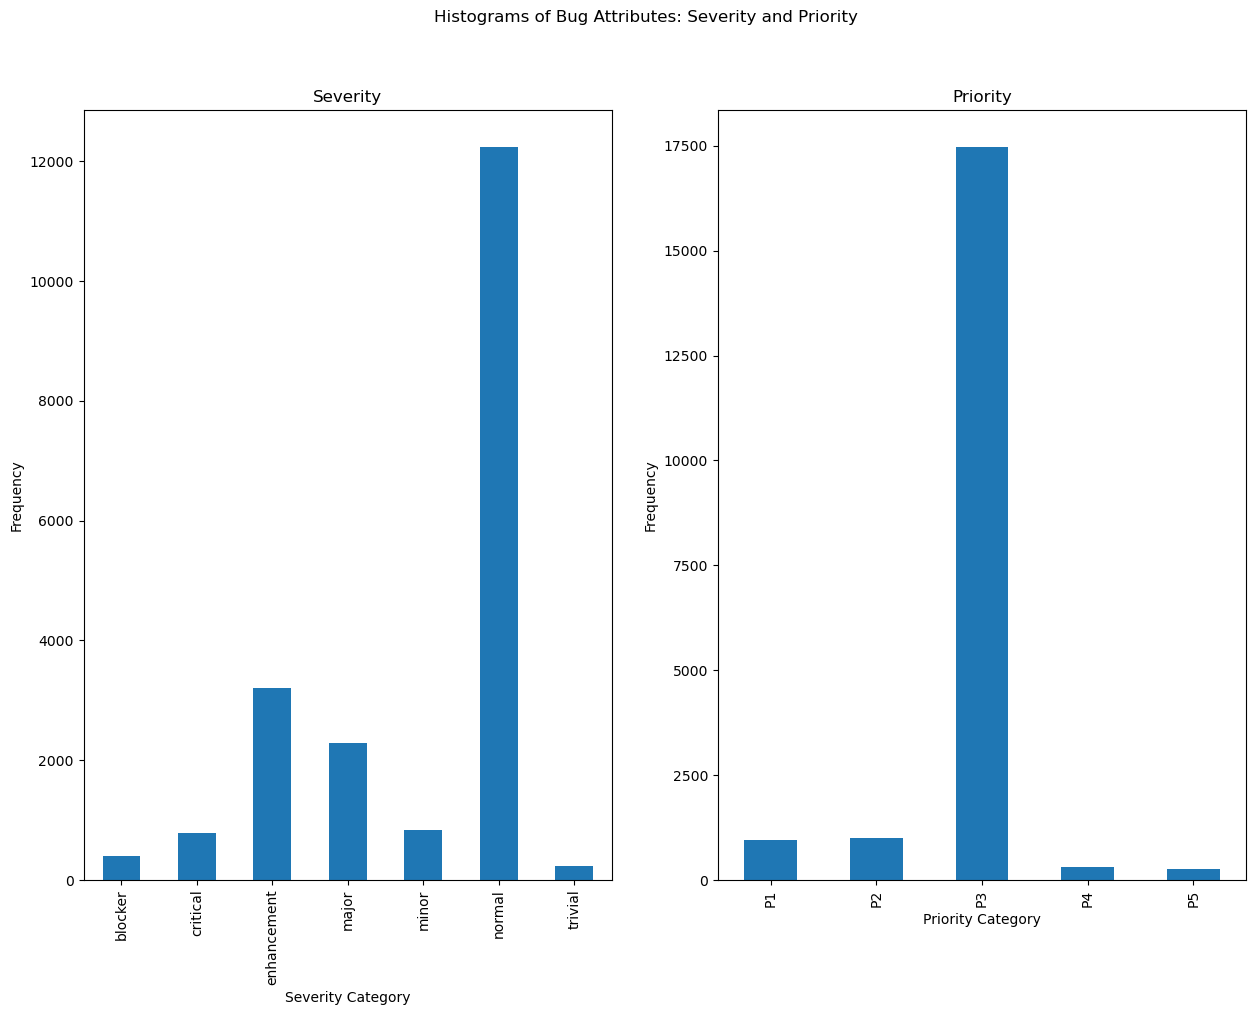

In [12]:
import matplotlib.pyplot as plt

# Convert 'severity' and 'priority' from categorical to numerical columns
severity_categories = bugs_df['severity'].astype('category')
priority_categories = bugs_df['priority'].astype('category')
bugs_df['severity_numerical'] = severity_categories.cat.codes
bugs_df['priority_numerical'] = priority_categories.cat.codes

# Plotting histograms for 'severity' and 'priority' numerical columns with categorical labels
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
severity_categories.value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Severity')
axes[0].set_xlabel('Severity Category')
axes[0].set_ylabel('Frequency')

priority_categories.value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Priority')
axes[1].set_xlabel('Priority Category')
axes[1].set_ylabel('Frequency')

plt.suptitle('Histograms of Bug Attributes: Severity and Priority')
plt.show()


## Tratamiento de datos faltantes

In [13]:
# Remove rows where the 'description' column is missing
bugs_df = bugs_df.dropna(subset=['description'])

# Description of the resulting dataset
print("\nDescription of the dataset after removing missing descriptions:")
print(bugs_df.describe(include='all'))



Description of the dataset after removing missing descriptions:
       severity                            title priority  \
count     19672                            19671    19672   
unique        7                            19300        5   
top      normal  Hygiene - no version tolerances       P3   
freq      12016                               10    17180   
mean        NaN                              NaN      NaN   
std         NaN                              NaN      NaN   
min         NaN                              NaN      NaN   
25%         NaN                              NaN      NaN   
50%         NaN                              NaN      NaN   
75%         NaN                              NaN      NaN   
max         NaN                              NaN      NaN   

                                              description keywords  \
count                                               19672    19672   
unique                                              19365     

# Aumento de datos

In [14]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.augmenter.word as naw

# Initialize various augmenters
aug_char = nac.OcrAug()
aug_key = nac.KeyboardAug()
aug_word_emb_sub = naw.WordEmbsAug(model_type='word2vec', model_path='GoogleNews-vectors-negative300.bin', action="substitute")
aug_word_emb_ins = naw.WordEmbsAug(model_type='word2vec', model_path='GoogleNews-vectors-negative300.bin', action="insert")
# aug_contextual_sub = naw.ContextualWordEmbsAug(model_path='distilbert/distilbert-base-uncased', action="substitute")
# aug_contextual_ins = naw.ContextualWordEmbsAug(model_path='distilbert/distilbert-base-uncased', action="insert")
aug_rand = naw.RandomWordAug()
aug_spelling = naw.SpellingAug()
aug_split = naw.SplitAug()
# aug_sentence = nas.ContextualWordEmbsForSentenceAug(model_path='xlnet-base-cased')

/Users/svillegasz/mambaforge/envs/unir/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
import math
# Function to augment data using multiple methods
def augment_data(data, num_augments):
    augmented_data = data.iloc[:0].copy()

    augmenters = [aug_char, aug_key, aug_word_emb_sub, aug_word_emb_ins, aug_rand, aug_spelling]
    #augmenters = [aug_char, aug_key, aug_word_emb_sub, aug_contextual_sub, aug_contextural_ins, aug_word_emb_ins, aug_rand, aug_spelling, aug_sentence]

    data_size = math.ceil(num_augments / (len(augmenters) * max(1, num_augments // len(data))))
    num_times_to_augment = math.ceil(num_augments / (len(augmenters) * data_size))       

    for augmenter in augmenters:
        sub_set = data.iloc[:data_size]
        result = []
        for _ in range(num_times_to_augment):
            result += augmenter.augment(sub_set['description'].to_list())
        
        for i in range(len(sub_set)):
            for j in range(i, len(result), len(sub_set)):
                next_row = sub_set.iloc[i].copy()
                next_row['description'] = result[j]
                augmented_data = pd.concat([augmented_data, pd.DataFrame([next_row])], ignore_index=True)

    return augmented_data.iloc[:num_augments]


# Randomly select rows for priority class "P3" and discard the others
p3_data = bugs_df[bugs_df['priority'] == 'P3'].sample(n=1002, random_state=42)
bugs_reduced_df = bugs_df[bugs_df['priority'] != 'P3']
bugs_reduced_df = pd.concat([bugs_reduced_df, p3_data], ignore_index=True)

# Balancing the 'priority' classes by augmenting under-represented classes
priority_counts = bugs_reduced_df['priority'].value_counts()
max_count = priority_counts.max()
bugs_augmented_df = bugs_reduced_df
# Augment data for each priority class
for priority, count in priority_counts.items():
    if count < max_count:
        # Filter data for the current priority
        priority_data = bugs_reduced_df[bugs_reduced_df['priority'] == priority]
        # Number of samples to generate
        num_samples_to_generate = max_count - count
        # Augment data
        augmented_data = augment_data(priority_data, num_samples_to_generate)
        # Append augmented data to the original dataframe
        bugs_augmented_df = pd.concat([bugs_augmented_df, augmented_data], ignore_index=True)

# Display the new value counts for the 'priority' column
print("New priority counts after augmentation:")
print(bugs_augmented_df['priority'].value_counts())



New priority counts after augmentation:
priority
P1    1002
P2    1002
P4    1002
P5    1002
P3    1002
Name: count, dtype: int64


# NLP

In [36]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.data import Dataset
import numpy as np

# Assuming 'description' is the text column we want to vectorize
descriptions = bugs_augmented_df['description'].to_list()

# Create a TextVectorization layer
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=500) 

# Create a dataset for the sample data
dataset = Dataset.from_tensor_slices(descriptions)

# Adapt the vectorizer to the dataset
vectorizer.adapt(dataset.batch(128))


print('Vocabulary:', vectorizer.get_vocabulary()[:10])
print('Vocabulary size:', len(vectorizer.get_vocabulary()))

# Create a vector of features using the vectorizer
features = vectorizer([[t] for t in descriptions]).numpy()

# Add the 'severity_numerical' column to the features vector
severity_numerical = bugs_augmented_df['severity_numerical'].values.reshape(-1, 1)
features = np.hstack((features, severity_numerical))

print('features:', features)
print('features shape:', np.shape(features))



2024-06-20 14:30:04.762870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary: ['', '[UNK]', 'the', 'at', 'to', 'a', 'in', 'and', 'is', 'of']
Vocabulary size: 20000
features: [[   57   150 14685 ...     0     0     5]
 [   32    70     5 ...     0     0     3]
 [  415     4    74 ...     0     0     5]
 ...
 [   14    35    11 ...     0     0     2]
 [   14    35    11 ...     0     0     2]
 [ 3412  3708    22 ...     0     0     2]]
features shape: (5010, 501)


# Feature augmentation

In [37]:
from sklearn.decomposition import LatentDirichletAllocation

# Assuming we have 10 topics
n_topics = 10

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(features)

# Transform the features vector into topic vectors
topic_vectors = lda.transform(features)

# Add the topic vector to the features vector
features = np.hstack((features, topic_vectors))
print('features:', features)
print('features shape:', np.shape(features))


features: [[5.70000000e+01 1.50000000e+02 1.46850000e+04 ... 2.49206323e-06
  2.49273142e-06 2.49214800e-06]
 [3.20000000e+01 7.00000000e+01 5.00000000e+00 ... 1.58052847e-06
  7.01156151e-01 1.58057781e-06]
 [4.15000000e+02 4.00000000e+00 7.40000000e+01 ... 2.20943601e-06
  5.97699059e-01 2.20950896e-06]
 ...
 [1.40000000e+01 3.50000000e+01 1.10000000e+01 ... 1.27022677e-06
  1.27039918e-06 1.27025092e-06]
 [1.40000000e+01 3.50000000e+01 1.10000000e+01 ... 2.04873379e-06
  2.04915090e-06 2.04879889e-06]
 [3.41200000e+03 3.70800000e+03 2.20000000e+01 ... 8.84109390e-07
  6.06220949e-02 1.07214395e-01]]
features shape: (5010, 511)


In [38]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import scipy.sparse
import scipy.sparse.csgraph
import pandas as pd


def _closeness_centrality(G):
    # Get adjacency matrix
    A = nx.adjacency_matrix(G)
    
    # Compute shortest path lengths using Floyd-Warshall algorithm
    D = scipy.sparse.csgraph.floyd_warshall(A, directed=False)
    
    # Number of nodes
    n = D.shape[0]
    
    closeness_centrality = {}
    
    for r in range(n):
        # Get distances from node r to all other nodes
        distances = D[r]
        
        # Consider only finite distances (reachable nodes)
        reachable_distances = distances[np.isfinite(distances)]
        
        # Number of reachable nodes (excluding itself)
        n_reachable = len(reachable_distances) - 1
        
        # Sum of reachable distances
        total_distance = np.sum(reachable_distances)
        
        # Calculate closeness centrality
        if total_distance > 0.0 and n > 1:
            s = n_reachable / (n - 1)
            cc = (n_reachable / total_distance) * s
            closeness_centrality[r] = cc
        else:
            closeness_centrality[r] = 0.0
    
    return closeness_centrality

# Create a CountVectorizer to get the frequency of terms
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(descriptions)

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with the term frequencies
term_frequencies = X.toarray()
print(descriptions[0])
values = {terms[i]: term_frequencies[0, i] for i in range(len(terms)) if term_frequencies[0, i] != 0}
print(values)

# Create a graph
G = nx.Graph()

G.add_nodes_from(terms)

# Create a sparse co-occurrence matrix
X_csr = X.tocsr()
cooccurrence_matrix = (X_csr.T @ X_csr).tocoo()

for i, j, v in zip(cooccurrence_matrix.row, cooccurrence_matrix.col, cooccurrence_matrix.data):
    if i != j:
        term1, term2 = terms[i], terms[j]
        G.add_edge(term1, term2, weight=v)

# Calculate centrality metrics
degree_centrality = nx.degree_centrality(G)
# closeness_centrality = _closeness_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G, k=30)

# Calculate the average centrality values
# average_centrality = {}
# for term in terms:
#     avg_value = (degree_centrality.get(term, 0) + betweenness_centrality.get(term, 0)) / 2
#     average_centrality[term] = avg_value

# Create a new vector for centrality values
centrality_values = np.zeros_like(term_frequencies, dtype=float)
for i in range(term_frequencies.shape[0]):
    for j in range(term_frequencies.shape[1]):
        term = terms[j]
        centrality_values[i, j] = term_frequencies[i, j] * degree_centrality[term] if term_frequencies[i, j] != 0 else 0

values = {terms[i]: centrality_values[0, i] for i in range(len(terms)) if centrality_values[0, i] != 0}
print(values)

# Add the centrality vector to the features vector
features = np.hstack((features, centrality_values))
print('features:', features)
print('features shape:', np.shape(features))



Test case: Trace.UI::Method Details_2

The test case says to verify that, if flow information is not collected, the Method Details view shows only the selected method and an error message explaining  why no data is shown. In the test, more data is shown than that. (See attached screen captures.)
{'an': 1, 'and': 1, 'attached': 1, 'captures': 1, 'case': 2, 'collected': 1, 'data': 2, 'details': 1, 'error': 1, 'flow': 1, 'if': 1, 'in': 1, 'information': 1, 'is': 3, 'message': 1, 'method': 3, 'more': 1, 'no': 1, 'not': 1, 'only': 1, 'says': 1, 'screen': 1, 'see': 1, 'selected': 1, 'shown': 2, 'shows': 1, 'test': 3, 'than': 1, 'that': 2, 'the': 4, 'to': 1, 'trace': 1, 'ui': 1, 'verify': 1, 'view': 1, 'why': 1}
{'an': 0.8837767553510703, 'and': 0.960992198439688, 'attached': 0.4786957391478296, 'captures': 0.033006601320264055, 'case': 1.1430286057211443, 'collected': 0.05661132226445289, 'data': 1.2254450890178035, 'details': 0.4236847369473895, 'error': 0.8165633126625325, 'flow': 0.095819

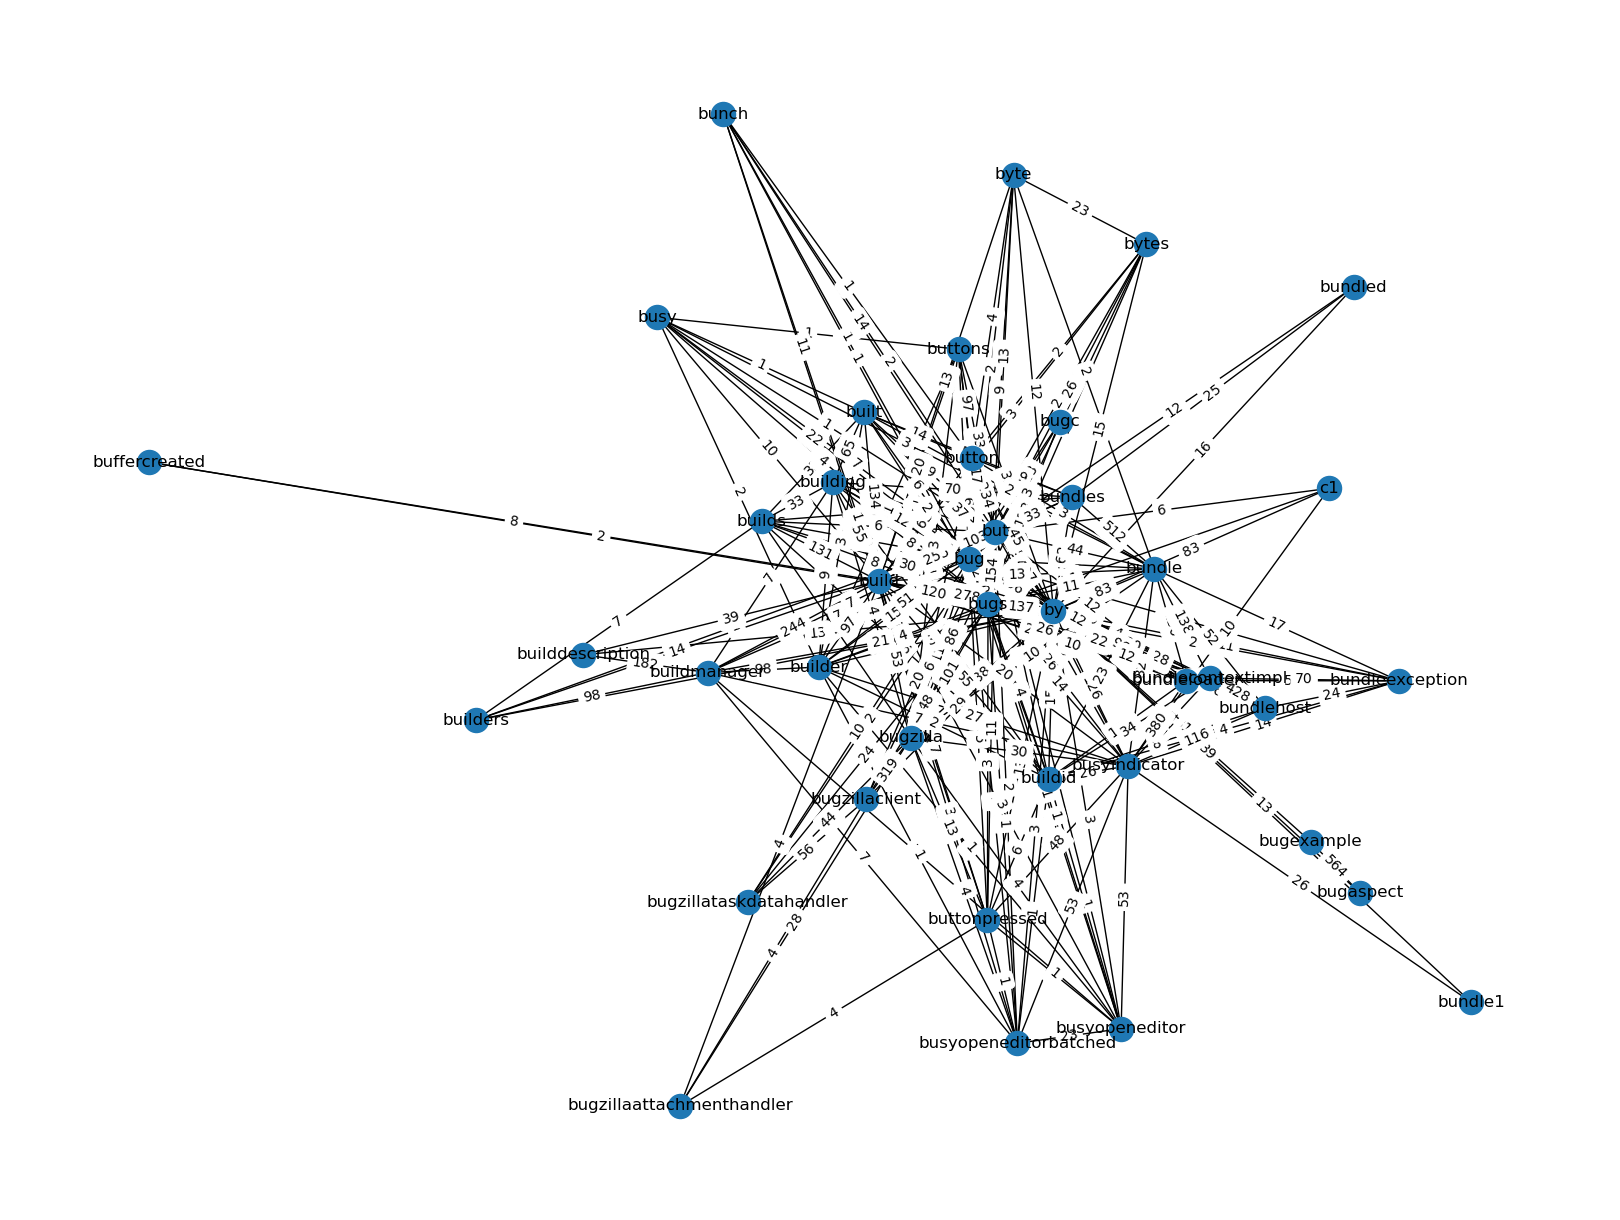

In [51]:
import matplotlib.pyplot as plt
import networkx as nx

# Draw a sub-graph with 50 nodes
sub_nodes = list(G.nodes())[1020:1060]
sub_G = G.subgraph(sub_nodes)

plt.figure(figsize=(16, 12))

# Draw the nodes and labels
pos = nx.spring_layout(sub_G)
nx.draw(sub_G, pos, with_labels=True)

# Draw the edge weights
edge_labels = nx.get_edge_attributes(sub_G, 'weight')
nx.draw_networkx_edge_labels(sub_G, pos, edge_labels=edge_labels)

plt.show()


# HAN

## Normalize features

In [2]:
from sklearn.preprocessing import StandardScaler

# Initialize a StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
features = scaler.fit_transform(features)

features


array([[-0.31763992, -0.33590418,  5.11772839, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [-0.32669084, -0.36417726, -0.40567656, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [-0.18803076, -0.38750255, -0.37971505, ..., -0.11880285,
        -0.02652238, -0.02640864],
       ...,
       [-0.3332075 , -0.37654673, -0.40341904, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [-0.3332075 , -0.37654673, -0.40341904, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [ 0.89699339,  0.92154115, -0.39928025, ..., -0.11880285,
        -0.02652238, -0.02640864]])

In [3]:
%store features

Stored 'features' (ndarray)


In [4]:
%store -r features
features

array([[-0.31763992, -0.33590418,  5.11772839, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [-0.32669084, -0.36417726, -0.40567656, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [-0.18803076, -0.38750255, -0.37971505, ..., -0.11880285,
        -0.02652238, -0.02640864],
       ...,
       [-0.3332075 , -0.37654673, -0.40341904, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [-0.3332075 , -0.37654673, -0.40341904, ..., -0.11880285,
        -0.02652238, -0.02640864],
       [ 0.89699339,  0.92154115, -0.39928025, ..., -0.11880285,
        -0.02652238, -0.02640864]])

In [16]:
import tensorflow as tf

# Assuming 'priority' is the target column
labels = bugs_augmented_df['priority_numerical'].values

# Convert the features and labels to TensorFlow Datasets
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

# Determine the number of examples in the dataset
dataset_size = len(list(dataset))

# Split the data into training and validation sets
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

# Shuffle the dataset
dataset = dataset.shuffle(dataset_size)

# Split the dataset into training and validation datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# Display the number of examples in the train and validation datasets
print("Training set size:", len(list(train_dataset)))
print("Validation set size:", len(list(val_dataset)))



2024-06-20 18:50:08.670600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 4008
Validation set size: 1002


2024-06-20 18:50:08.991512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-20 18:50:09.135769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:

# Define the Hierarchical Attention Network (HAN) model
class HAN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_units):
        super(HAN, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.word_encoder = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hidden_units, return_sequences=True))
        self.word_attention = tf.keras.layers.Attention()
        self.flatten1 = tf.keras.layers.Flatten()  # Added Flatten layer
        self.dense = tf.keras.layers.Dense(hidden_units, activation='relu')  # Added Dense layer
        self.repeat_vector = tf.keras.layers.RepeatVector(hidden_units)  # Added RepeatVector layer
        self.sentence_encoder = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hidden_units, return_sequences=True))
        self.sentence_attention = tf.keras.layers.Attention()
        self.flatten2 = tf.keras.layers.Flatten()  # Added another Flatten layer
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        x_word = self.word_encoder(x)
        word_attention_weights = self.word_attention([x_word, x_word])
        flattened_vector = self.flatten1(word_attention_weights * x_word)  # Applied Flatten layer
        dense_vector = self.dense(flattened_vector)  # Applied Dense layer
        repeated_vector = self.repeat_vector(dense_vector)  # Applied RepeatVector layer
        x_sentence = self.sentence_encoder(repeated_vector)
        sentence_attention_weights = self.sentence_attention([x_sentence, x_sentence])
        flattened_sentence_vector = self.flatten2(sentence_attention_weights * x_sentence)  # Applied another Flatten layer
        output = self.classifier(flattened_sentence_vector)
        return output

# Instantiate the HAN model
han_model = HAN(vocab_size=20000, embedding_dim=128, hidden_units=64)

# Compile the HAN model
han_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the HAN model
han_model.fit(train_dataset.batch(128), validation_data=val_dataset.batch(128), epochs=5)




Epoch 1/5
 6/32 ━━━━━━━━━━━━━━━━━━━━ 1:38:49 228s/step - accuracy: 0.1913 - loss: -0.8868

: 

# Evaluation

In [ ]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = han_model.evaluate(val_dataset)

# Print the evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate predictions on the validation dataset
val_predictions = han_model.predict(val_dataset)

# Convert predictions to binary outcomes
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Collect true labels from the validation dataset
val_labels = []
for _, label in val_dataset:
    val_labels.append(label.numpy())

# Flatten the list of true labels
val_labels = [item for sublist in val_labels for item in sublist]

# Calculate additional evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

# Generate classification report
print("Classification Report:")
print(classification_report(val_labels, val_predictions_binary))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_predictions_binary))

# Calculate precision and recall
precision = precision_score(val_labels, val_predictions_binary)
recall = recall_score(val_labels, val_predictions_binary)

# Print precision and recall
print(f"Precision: {precision}")
print(f"Recall: {recall}")

